In [1]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
import os
import pandas as pd

dataset_filename = os.listdir("C:/data/twitter")[0]
dataset_path = os.path.join("..","C:/data/twitter",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: C:/data/twitter\testset.csv


In [6]:
print("Dataset size:", len(df))

Dataset size: 20000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 8.98 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

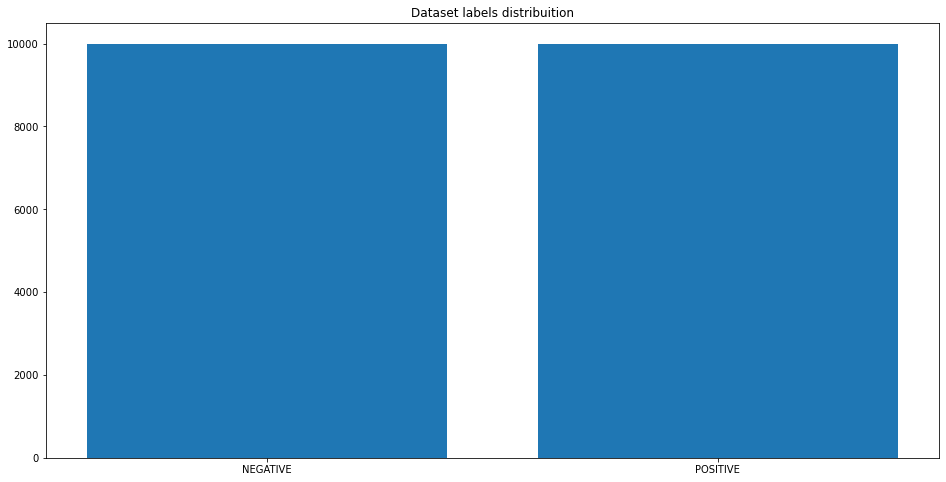

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Pre-Process dataset

In [11]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
import re

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 586 ms


## Split train and test

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 16000
TEST size: 4000


## Word2Vec

In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 16.9 ms


In [16]:
import gensim

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [17]:
w2v_model.build_vocab(documents)

2020-08-26 11:27:41,973 : INFO : collecting all words and their counts
2020-08-26 11:27:41,973 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-26 11:27:41,991 : INFO : PROGRESS: at sentence #10000, processed 71770 words, keeping 13635 word types
2020-08-26 11:27:42,005 : INFO : collected 18210 word types from a corpus of 114771 raw words and 16000 sentences
2020-08-26 11:27:42,006 : INFO : Loading a fresh vocabulary
2020-08-26 11:27:42,017 : INFO : effective_min_count=10 retains 1653 unique words (9% of original 18210, drops 16557)
2020-08-26 11:27:42,018 : INFO : effective_min_count=10 leaves 83838 word corpus (73% of original 114771, drops 30933)
2020-08-26 11:27:42,024 : INFO : deleting the raw counts dictionary of 18210 items
2020-08-26 11:27:42,026 : INFO : sample=0.001 downsamples 64 most-common words
2020-08-26 11:27:42,027 : INFO : downsampling leaves estimated 73907 word corpus (88.2% of prior 83838)
2020-08-26 11:27:42,032 : INFO : estimated

In [18]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1653


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-08-26 11:27:46,192 : INFO : training model with 8 workers on 1653 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-08-26 11:27:46,262 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-26 11:27:46,266 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-26 11:27:46,269 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-26 11:27:46,272 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-26 11:27:46,273 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-26 11:27:46,277 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-26 11:27:46,278 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-26 11:27:46,280 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-26 11:27:46,281 : INFO : EPOCH - 1 : training on 114771 raw words (73901 effective words) took 0.1s, 990361 effecti

Wall time: 2.84 s


(2364775, 3672672)

In [20]:
w2v_model.most_similar("love")

C:\Users\student\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-08-26 11:27:50,022 : INFO : precomputing L2-norms of word weight vectors


[('mention', 0.6828263998031616),
 ('brothers', 0.6614351868629456),
 ('lmfao', 0.6505697965621948),
 ('lady', 0.6142158508300781),
 ('smile', 0.6129683256149292),
 ('listen', 0.6077317595481873),
 ('followfriday', 0.6059358716011047),
 ('hilarious', 0.604072630405426),
 ('amazing', 0.6037734746932983),
 ('ii', 0.6011022925376892)]

In [21]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

# %%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1

print("Total words", vocab_size)

Total words 18211


In [22]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

## Label Encoder

In [23]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [26]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (16000, 1)
y_test (4000, 1)


In [27]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (16000, 300)
y_train (16000, 1)

x_test (4000, 300)
y_test (4000, 1)


In [28]:
y_train[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [29]:
import numpy as np

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(18211, 300)


In [30]:
from keras.layers.embeddings import Embedding

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## Build Model

In [31]:
from keras import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          5463300   
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 5,623,801
Trainable params: 160,501
Non-trainable params: 5,463,300
_________________________________________________________________


## Compile Model

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Callbacks

In [33]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

## Train

In [34]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
15/15 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.6574WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-08-26 11:30:47,436 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


15/15 [==============================] - 130s 9s/step - loss: 0.6215 - accuracy: 0.6574 - val_loss: 0.5779 - val_accuracy: 0.6931
Epoch 2/8
15/15 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.6965 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-08-26 11:33:25,784 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


15/15 [==============================] - 149s 10s/step - loss: 0.5772 - accuracy: 0.6965 - val_loss: 0.5569 - val_accuracy: 0.7131
Epoch 3/8
15/15 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.7035 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-08-26 11:36:24,629 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


15/15 [==============================] - 167s 11s/step - loss: 0.5663 - accuracy: 0.7035 - val_loss: 0.5475 - val_accuracy: 0.7175
Epoch 4/8
15/15 [==============================] - ETA: 0s - loss: 0.5622 - accuracy: 0.7060 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-08-26 11:39:31,827 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


15/15 [==============================] - 174s 12s/step - loss: 0.5622 - accuracy: 0.7060 - val_loss: 0.5424 - val_accuracy: 0.7212
Epoch 5/8
15/15 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.7104 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-08-26 11:42:48,130 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


15/15 [==============================] - 183s 12s/step - loss: 0.5579 - accuracy: 0.7104 - val_loss: 0.5384 - val_accuracy: 0.7250
Epoch 6/8
15/15 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.7128 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-08-26 11:46:16,276 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


15/15 [==============================] - 194s 13s/step - loss: 0.5506 - accuracy: 0.7128 - val_loss: 0.5366 - val_accuracy: 0.7212
Epoch 7/8
15/15 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.7156 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-08-26 11:49:53,398 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


15/15 [==============================] - 202s 13s/step - loss: 0.5487 - accuracy: 0.7156 - val_loss: 0.5343 - val_accuracy: 0.7225
Epoch 8/8
15/15 [==============================] - ETA: 0s - loss: 0.5455 - accuracy: 0.7171 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-08-26 11:53:41,241 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


15/15 [==============================] - 212s 14s/step - loss: 0.5455 - accuracy: 0.7171 - val_loss: 0.5323 - val_accuracy: 0.7356
Wall time: 25min 15s


## Evaluate

In [36]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4/4 [==============================] - 4s 884ms/step - loss: 0.5416 - accuracy: 0.7140

ACCURACY: 0.7139999866485596
LOSS: 0.5415639877319336
Wall time: 4.85 s


In [37]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [38]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [39]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9368957281112671,
 'elapsed_time': 0.23552179336547852}

In [40]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.07804980874061584,
 'elapsed_time': 0.055348873138427734}

In [66]:
predict("Isn't he a holy terror?")

{'label': 'NEUTRAL',
 'score': 0.4254371225833893,
 'elapsed_time': 0.05186271667480469}

## 작은아씨들 인물별 감성 분석

In [59]:
import pandas as pd

fname = 'C:/data/fiction/new_little_women.csv'
csv = pd.read_csv(fname)
df_new = pd.DataFrame(csv)
df_amy = df_new[df_new['speaker']=='AMY']
df_meg = df_new[df_new['speaker']=='MEG']
df_jo = df_new[df_new['speaker']=='JO']
df_beth = df_new[df_new['speaker']=='BETH']
df_beth

,Unnamed: 0,speaker,text,token,score
43,43,BETH,"Oh, Hello.","['oh', 'hello']",2
45,45,BETH,Are they coming?,"['are', 'they', 'coming']",2
58,58,BETH,Jo.,['jo'],2
60,60,BETH,For me?,"['for', 'me']",2
64,64,BETH,I don't know.,"['i', ""don't"", 'know']",2
68,68,BETH,Then _c Then I'd like to spend mine for some n...,"['then', 'c', 'then', ""i'd"", 'like', 'to', 'sp...",2
82,82,BETH,Birds in their little nests agree.,"['birds', 'in', 'their', 'little', 'nests', 'a...",2
86,86,BETH,Look.,['look'],2
100,100,BETH,Mmm.,['mmm'],2
102,102,BETH,"Did you have a hard day, Marmee?","['did', 'you', 'have', 'a', 'hard', 'day', 'ma...",2


In [70]:
amy = []
meg = []
jo = []
beth = []

for line in df_amy['text']:
    amy.append(predict(line)['score'])

for line in df_meg['text']:
    meg.append(predict(line)['score'])

for line in df_jo['text']:
    jo.append(predict(line)['score'])

for line in df_beth['text']:
    beth.append(predict(line)['score'])
    
print(amy)
print(meg)
print(jo)
print(beth)

[0.7364735007286072, 0.8864669799804688, 0.8864669799804688, 0.17961427569389343, 0.7622740864753723, 0.5643542408943176, 0.43216994404792786, 0.7480452656745911, 0.6040159463882446, 0.5377864241600037, 0.5027422904968262, 0.810124397277832, 0.7653998732566833, 0.6292091608047485, 0.5590923428535461, 0.5643542408943176, 0.5643542408943176, 0.5379641652107239, 0.6212735772132874, 0.4236399531364441, 0.8507384061813354, 0.7450882196426392, 0.5174452066421509, 0.8087920546531677, 0.48025187849998474, 0.6565882563591003, 0.48025187849998474, 0.5643542408943176, 0.5643542408943176, 0.4559657871723175, 0.5815441608428955, 0.5643542408943176, 0.5643542408943176, 0.5643542408943176, 0.652114748954773, 0.5643542408943176, 0.4883812963962555, 0.5643542408943176, 0.5643542408943176, 0.4434277415275574, 0.665512204170227, 0.5090979933738708, 0.7170064449310303, 0.4781533479690552, 0.9270026683807373, 0.5643542408943176, 0.5643542408943176, 0.5643542408943176, 0.5643542408943176, 0.5643542408943176

## 시각화

Text(0, 0.5, 'Emotion')

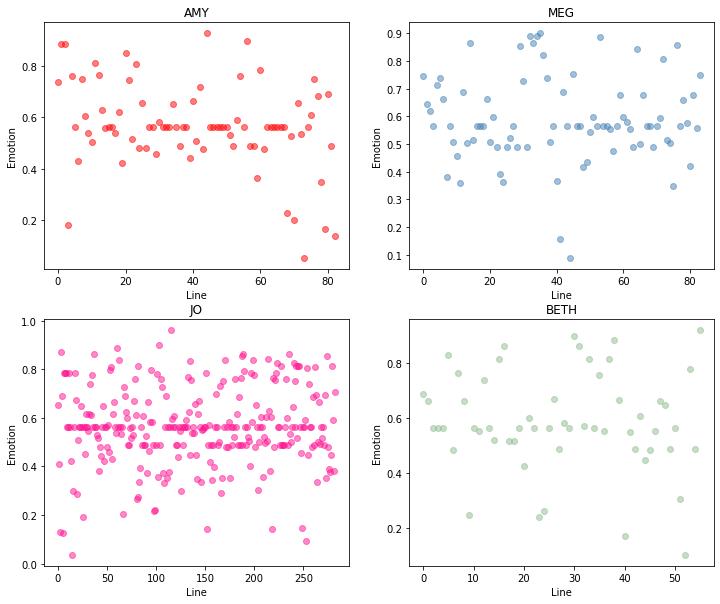

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

axes = plt.subplot(2,2,1)
x = list(range(0,len(amy)))
plt.scatter(x, amy, color='red', alpha=0.5)
plt.title('AMY')
plt.xlabel('Line')
plt.ylabel('Emotion')

axes = plt.subplot(2,2,2)
x = list(range(0,len(meg)))
plt.scatter(x, meg, color='steelblue', alpha=0.5)
plt.title('MEG')
plt.xlabel('Line')
plt.ylabel('Emotion')

axes = plt.subplot(2,2,3)
x = list(range(0,len(jo)))
plt.scatter(x, jo, color='deeppink', alpha=0.5)
plt.title('JO')
plt.xlabel('Line')
plt.ylabel('Emotion')

axes = plt.subplot(2,2,4)
x = list(range(0,len(beth)))
plt.scatter(x, beth,color='darkseagreen', alpha=0.5)
plt.title('BETH')
plt.xlabel('Line')
plt.ylabel('Emotion')

In [65]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 0s 0s/step
Wall time: 4.91 s


In [67]:
 def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

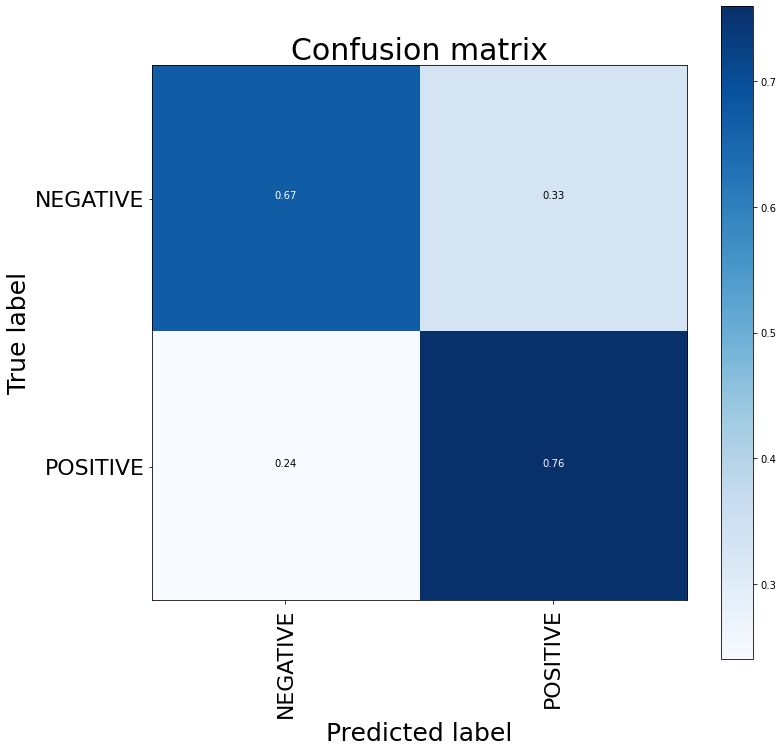

Wall time: 273 ms


In [68]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [69]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.74      0.67      0.70      2019
    POSITIVE       0.69      0.76      0.72      1981

    accuracy                           0.71      4000
   macro avg       0.72      0.71      0.71      4000
weighted avg       0.72      0.71      0.71      4000



In [46]:
accuracy_score(y_test_1d, y_pred_1d)

0.715

In [47]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-08-25 16:25:44,696 : INFO : saving Word2Vec object under model.w2v, separately None
2020-08-25 16:25:44,696 : INFO : not storing attribute vectors_norm
2020-08-25 16:25:44,696 : INFO : not storing attribute cum_table
2020-08-25 16:25:44,758 : INFO : saved model.w2v
